In [171]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob, re
from scipy.io import loadmat
import scipy.signal as sp
import scipy.optimize as op
import nanosphere_utils as ns
import importlib
from matplotlib.backends.backend_pdf import PdfPages

In [201]:
data_path = '/Users/dcmoore/Desktop/nanosphere_data/' #"/Volumes/DATA/nanosphere_data"

data_folder = '20240724_minus_one_e_data/20240724_50v_1_8e-8mbar'
#data_folder = '20240723_minus_one_e_data/20240723_20v_2e-8mbar'

plots_path = '/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/nanospheres/analysis'


In [202]:
combined_path = os.path.join(data_path, data_folder, '**/*.mat')
data_files = glob.glob(combined_path, recursive=True)

In [203]:
print(data_files)

['/Users/dcmoore/Desktop/nanosphere_data/20240724_minus_one_e_data/20240724_50v_1_8e-8mbar/20240724-0002/20240724-0002_4.mat', '/Users/dcmoore/Desktop/nanosphere_data/20240724_minus_one_e_data/20240724_50v_1_8e-8mbar/20240724-0002/20240724-0002_1.mat', '/Users/dcmoore/Desktop/nanosphere_data/20240724_minus_one_e_data/20240724_50v_1_8e-8mbar/20240724-0002/20240724-0002_3.mat', '/Users/dcmoore/Desktop/nanosphere_data/20240724_minus_one_e_data/20240724_50v_1_8e-8mbar/20240724-0002/20240724-0002_2.mat', '/Users/dcmoore/Desktop/nanosphere_data/20240724_minus_one_e_data/20240724_50v_1_8e-8mbar/20240724-0005/20240724-0005_3.mat', '/Users/dcmoore/Desktop/nanosphere_data/20240724_minus_one_e_data/20240724_50v_1_8e-8mbar/20240724-0005/20240724-0005_2.mat', '/Users/dcmoore/Desktop/nanosphere_data/20240724_minus_one_e_data/20240724_50v_1_8e-8mbar/20240724-0005/20240724-0005_1.mat', '/Users/dcmoore/Desktop/nanosphere_data/20240724_minus_one_e_data/20240724_50v_1_8e-8mbar/20240724-0005/20240724-0005

/var/folders/35/ft5fljg94_x6xpzhzn_wtctr0000gn/T/ipykernel_50671/3273409008.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  time = np.arange(0, len(sphere_z)*tstep, tstep)


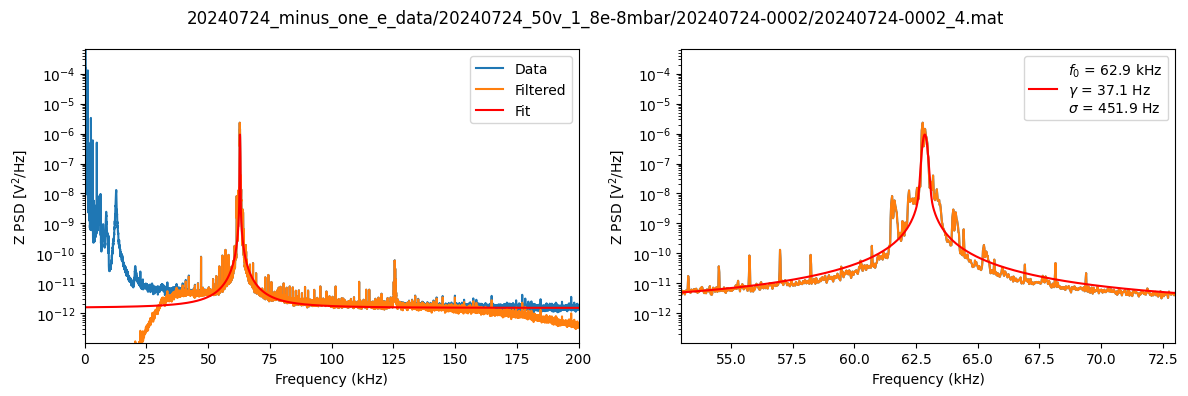

/var/folders/35/ft5fljg94_x6xpzhzn_wtctr0000gn/T/ipykernel_50671/3273409008.py:152: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed two minor releases later.
  pdf.close()


In [241]:
importlib.reload(ns)

remake_files = True
save_plot = True

filt_band = [30e3, 200e3]
wind_size = 1e-3 ## fitting window in seconds
omega0 = 2*np.pi*64.5e3 ## resonant frequency guess
low_pass_freq = 100e3 ## low pass filter frequency

##############################################################

curr_plots_path = os.path.join(plots_path, data_folder)   
if not os.path.exists(curr_plots_path):
    os.makedirs(curr_plots_path)

if(remake_files):

    fit_amps = []
    noise_amps = []

    tf_sig_pdf = PdfPages(os.path.join(curr_plots_path, 'transfer_func_fit_calibration.pdf'))
    psd_sig_pdf = PdfPages(os.path.join(curr_plots_path, 'force_psd_calibration.pdf'))
    waveform_sig_pdf = PdfPages(os.path.join(curr_plots_path, 'waveform_calibration.pdf'))
    tf_noise_pdf = PdfPages(os.path.join(curr_plots_path, 'transfer_func_fit_noise.pdf'))
    psd_noise_pdf = PdfPages(os.path.join(curr_plots_path, 'force_psd_noise.pdf'))
    waveform_noise_pdf = PdfPages(os.path.join(curr_plots_path, 'waveform_noise.pdf'))

    for df_idx, data_file in enumerate(data_files):
        data = loadmat(data_file)

        sphere_z = np.ndarray.flatten(data['D'])
        drive = np.ndarray.flatten(data['G'])
        tstep = data['Tinterval'][0]
        time = np.arange(0, len(sphere_z)*tstep, tstep)

        filtered_data = ns.get_filtered_data(time, sphere_z, drive, filt_band, tstep, make_plot=False) 

        if(df_idx == 0):
            fig=plt.figure(figsize=(12,4))
            ns.get_psd(sphere_z, tstep, filtered_data = filtered_data, make_plot = True, fig=fig)
            plt.suptitle(data_file.removeprefix(data_path))
            if(save_plot):
                plt.tight_layout()
                plt.savefig(os.path.join(curr_plots_path, 'psd.pdf'))
            plt.show()

        ## now find the impulses and step through each one, plotting and fitting
        impulse_idxs = ns.find_impulses(drive, make_plot=False)

        if(save_plot):
            tf_fig = plt.figure(figsize = (12, len(impulse_idxs)*5))
            psd_fig = plt.figure(figsize = (12, len(impulse_idxs)*5))
            waveform_fig = plt.figure(figsize = (12, len(impulse_idxs)*5))


        for plot_idx, idx in enumerate(impulse_idxs):

            print("Working on impulse at time: ", time[idx])    

            curr_window = [time[idx]-wind_size, time[idx]+wind_size]

            if(save_plot):

                plt.figure(tf_fig.number)
                plt.subplot(len(impulse_idxs), 1, plot_idx+1)
                tf_ax = plt.gca()

                plt.figure(psd_fig.number)
                plt.subplot(len(impulse_idxs), 1, plot_idx+1)
                psd_ax = plt.gca()

                plt.figure(waveform_fig.number)
                plt.subplot(len(impulse_idxs), 1, plot_idx+1)
                waveform_ax = plt.gca()

                ax_list = [psd_ax, tf_ax, waveform_ax]

            if(False):
                plt.figure(figsize=(12,4))
                fit_points = (time > curr_window[0]) & (time < curr_window[1])
                t, z, fz = time[fit_points], sphere_z[fit_points], filtered_data[fit_points]
                plt.plot(t, z, label='Data')
                plt.plot(t, fz, label='Filtered')
                plt.legend()
                plt.xlabel('Time (s)')
                plt.ylabel('Z position (V)')
                plt.show()


            amp, amp_lp, force_norm, f0, gamma = ns.deconvolve_force_amp(time, filtered_data, curr_window, lp_freq=low_pass_freq, make_plot=save_plot, ax_list=ax_list)

            fit_amps.append([amp, amp_lp, force_norm, f0, gamma])

        if(save_plot):
            for cfile, cfig in zip([tf_sig_pdf, psd_sig_pdf, waveform_sig_pdf], [tf_fig, psd_fig, waveform_fig]):
                plt.figure(cfig.number)
                plt.tight_layout()
                plt.subplots_adjust(top=0.95)
                plt.suptitle(data_file.removeprefix(data_path))
                cfile.savefig(cfig)



        noise_idxs = impulse_idxs[:-1] + 0.75*np.diff(impulse_idxs) ## go away from pulse time

        if(save_plot):
            tf_fig_noise = plt.figure(figsize = (12, len(noise_idxs)*5))
            psd_fig_noise = plt.figure(figsize = (12, len(noise_idxs)*5))
            waveform_fig_noise = plt.figure(figsize = (12, len(noise_idxs)*5))

        for plot_idx, nidx in enumerate(noise_idxs):
            
            nidx = int(nidx)
            print("Working on noise at time: ", time[nidx])    

            curr_window = [time[nidx]-wind_size, time[nidx]+wind_size]

            if(save_plot):

                plt.figure(tf_fig_noise.number)
                plt.subplot(len(noise_idxs), 1, plot_idx+1)
                tf_ax = plt.gca()

                plt.figure(psd_fig_noise.number)
                plt.subplot(len(noise_idxs), 1, plot_idx+1)
                psd_ax = plt.gca()

                plt.figure(waveform_fig_noise.number)
                plt.subplot(len(noise_idxs), 1, plot_idx+1)
                waveform_ax = plt.gca()

                ax_list = [psd_ax, tf_ax, waveform_ax]
            
            amp, amp_lp, force_norm, f0, gamma = ns.deconvolve_force_amp(time, filtered_data, curr_window, lp_freq=low_pass_freq, make_plot=save_plot, ax_list=ax_list)

            noise_amps.append([amp, amp_lp, force_norm, f0, gamma])

        if(save_plot):
            for cfile, cfig in zip([tf_noise_pdf, psd_noise_pdf, waveform_noise_pdf], [tf_fig_noise, psd_fig_noise, waveform_fig_noise]):
                plt.figure(cfig.number)
                plt.tight_layout()
                plt.subplots_adjust(top=0.95)
                plt.suptitle(data_file.removeprefix(data_path))
                cfile.savefig(cfig)

    if(save_plot):
        pdf_list = [tf_sig_pdf, psd_sig_pdf, waveform_sig_pdf, tf_noise_pdf, psd_noise_pdf, waveform_noise_pdf]
        for pdf in pdf_list:
            pdf.close()
        plt.close('all')

    fit_amps = np.array(fit_amps)
    noise_amps = np.array(noise_amps)

    ## get voltage amplitude from file name
    drive_voltage = float(re.findall(r'_\d+v_',data_file)[0][1:-2])
    impulse_amplitude = drive_voltage * 0.198 ## MeV/c, assuming 5.5 us long pulse at 120V/m per V drive

    np.savez(os.path.join(curr_plots_path, 'reconstructed_data.npz'), fit_amps=fit_amps, noise_amps=noise_amps, impulse_amplitude=impulse_amplitude)

else:

    data = np.load(os.path.join(curr_plots_path, 'reconstructed_data.npz'))
    fit_amps = data['fit_amps']
    noise_amps = data['noise_amps']
    impulse_amplitude = data['impulse_amplitude']

In [198]:
def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

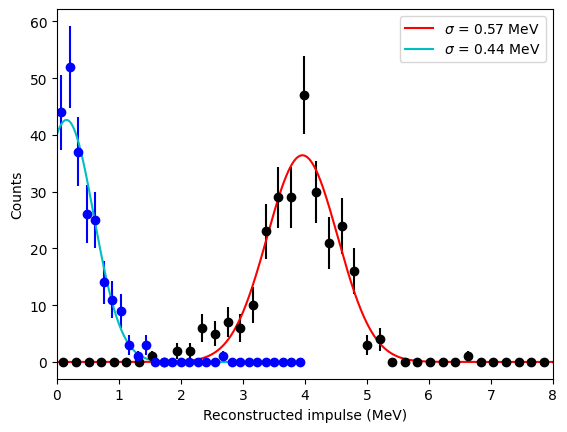

In [200]:
normed_amps = fit_amps[:,1] #/fit_amps[:,2]
bins = np.linspace(0, np.max(np.abs(normed_amps))*1.5, 50)
hh, be = np.histogram(np.abs(normed_amps), bins=bins)
bc = 0.5*(be[1:]+be[:-1])

gp, gcov = op.curve_fit(gauss, bc, hh, p0=[np.max(hh), np.mean(np.abs(normed_amps)), np.std(np.abs(normed_amps))])

cal_fac = impulse_amplitude/gp[1]

xx = np.linspace(0,np.max(bc),1000)

normed_noise = noise_amps[:,1] #/noise_amps[:,2]
noise_bins = np.linspace(0, np.max(np.abs(normed_noise))*1.5, 30)
hh_noise, be = np.histogram(np.abs(normed_noise), bins=noise_bins)
bc_noise = 0.5*(be[1:]+be[:-1])
errs = np.sqrt(hh_noise)
errs[errs==0] = 1
spars = [np.max(hh_noise), np.std(np.abs(normed_noise))]
noise_gauss = lambda x, A, sigma: gauss(x, A, 0.2, sigma)    
gp_noise, gcov_noise = op.curve_fit(noise_gauss, bc_noise, hh_noise, p0=spars, sigma=errs)

xx_noise = np.linspace(0,np.max(bc_noise),1000)

plt.figure()
plt.errorbar(bc*cal_fac, hh, yerr=np.sqrt(hh), fmt='ko')
plt.plot(xx*cal_fac, gauss(xx, *gp), 'r', label="$\sigma$ = %.2f MeV" % (gp[2]*cal_fac))
plt.errorbar(bc_noise*cal_fac, hh_noise, yerr=np.sqrt(hh_noise), fmt='bo')
plt.plot(xx_noise*cal_fac, noise_gauss(xx_noise, *gp_noise), 'c', label="$\sigma$ = %.2f MeV" % (gp_noise[1]*cal_fac))
plt.xlim(0,8) #np.max(bc)*cal_fac)
plt.xlabel("Reconstructed impulse (MeV)")
plt.ylabel("Counts")
plt.legend()
plt.show()


In [180]:
## loop over all the amplitudes and plot

data_folder_list = ['20240723_minus_one_e_data/20240723_5v_2e-8mbar',
                    '20240723_minus_one_e_data/20240723_10v_2e-8mbar',
                    '20240723_minus_one_e_data/20240723_20v_2e-8mbar',
                    '20240724_minus_one_e_data/20240724_50v_1_8e-8mbar',
                    '20240724_minus_one_e_data/20240724_100v_1_8e-8mbar',
                    '20240724_minus_one_e_data/20240724_150v_1_8e-8mbar']

(0.0, 4.0)

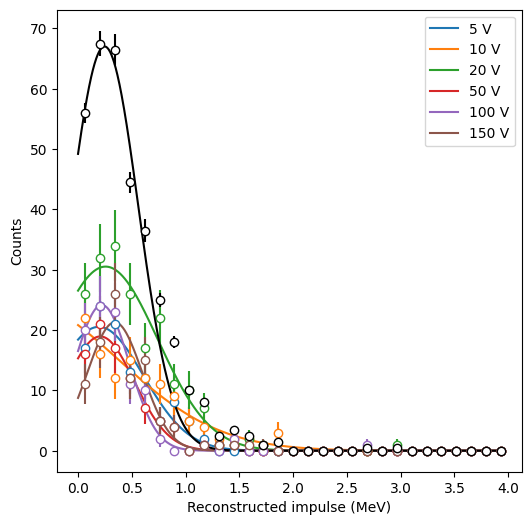

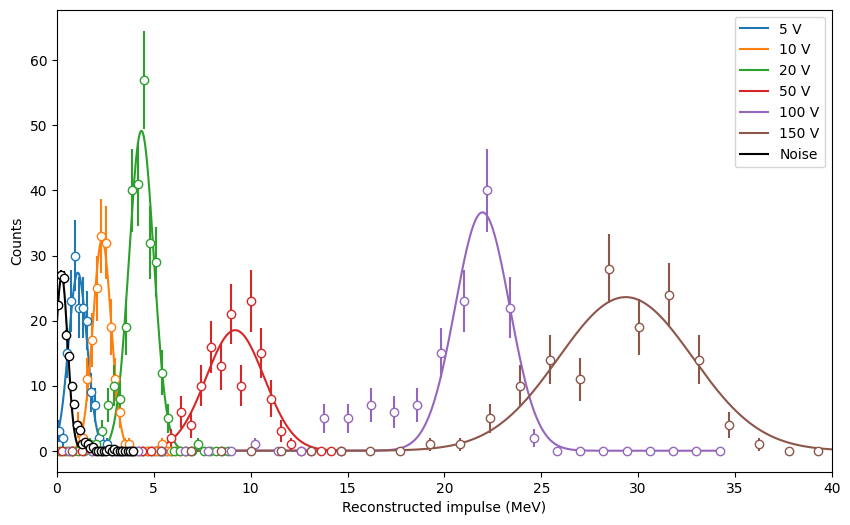

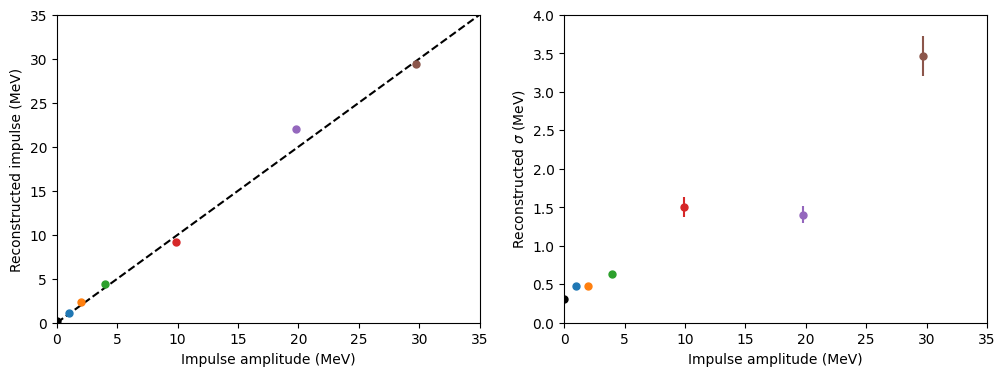

In [183]:
approx_cal_fac = 0.85
fit_figure = plt.figure(figsize=(10,6))

color_list = ['tab:blue', "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", 'k']

fit_values = []

for df_idx, data_folder in enumerate(data_folder_list):

    curr_plots_path = os.path.join(plots_path, data_folder)   

    data = np.load(os.path.join(curr_plots_path, 'reconstructed_data.npz'))
    fit_amps = data['fit_amps']
    noise_amps = data['noise_amps']
    impulse_amplitude = data['impulse_amplitude']

    if(impulse_amplitude < 10):
        bins = np.linspace(0, impulse_amplitude+5, 30)
    else:
        bins = np.linspace(0, impulse_amplitude+15, 30)

    normed_amps = fit_amps[:,1]*approx_cal_fac
    hh, be = np.histogram(normed_amps, bins=bins)
    bc = 0.5*(be[1:]+be[:-1])

    gp, gcov = op.curve_fit(gauss, bc, hh, p0=[np.max(hh), np.mean(np.abs(normed_amps)), np.std(np.abs(normed_amps))])
    xx = np.linspace(0,np.max(bc),1000) 

    fit_values.append([impulse_amplitude, gp[1], gp[2], np.sqrt(np.diag(gcov))[1], np.sqrt(np.diag(gcov))[2]])

    drive_voltage = float(re.findall(r'_\d+v_', data_folder)[0][1:-2])

    plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='o', color=color_list[df_idx], markerfacecolor='white')
    plt.plot(xx, gauss(xx, *gp), color=color_list[df_idx], label="%d V"%drive_voltage)
    plt.xlabel("Reconstructed impulse (MeV)")
    plt.ylabel("Counts")

noise_figure = plt.figure(figsize=(6,6))

## now noise
bins = np.linspace(0, 4, 30)
tot_noise = np.zeros(len(bins)-1)
for df_idx, data_folder in enumerate(data_folder_list):

    curr_plots_path = os.path.join(plots_path, data_folder)   

    data = np.load(os.path.join(curr_plots_path, 'reconstructed_data.npz'))
    fit_amps = data['fit_amps']
    noise_amps = data['noise_amps']
    impulse_amplitude = data['impulse_amplitude']

    normed_amps = noise_amps[:,1]*approx_cal_fac
    hh, be = np.histogram(normed_amps, bins=bins)
    bc = 0.5*(be[1:]+be[:-1])
    tot_noise += hh

    gp, gcov = op.curve_fit(gauss, bc, hh, p0=[np.max(hh), np.mean(np.abs(normed_amps)), np.std(np.abs(normed_amps))])
    xx = np.linspace(0,np.max(bc),1000) 

    #fit_values.append([impulse_amplitude, gp[1], gp[2], np.sqrt(np.diag(gcov))[1], np.sqrt(np.diag(gcov))[2]])

    drive_voltage = float(re.findall(r'_\d+v_', data_folder)[0][1:-2])

    plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='o', color=color_list[df_idx], markerfacecolor='white')
    plt.plot(xx, gauss(xx, *gp), color=color_list[df_idx], label="%d V"%drive_voltage)
    plt.legend()
    plt.xlabel("Reconstructed impulse (MeV)")
    plt.ylabel("Counts")    

fpts = bc < 0.7
gp, gcov = op.curve_fit(gauss, bc[fpts], tot_noise[fpts], p0=[np.max(tot_noise), np.mean(np.abs(normed_amps)), np.std(np.abs(normed_amps))])

scale_fac = 2
plt.errorbar(bc, tot_noise/scale_fac, yerr=np.sqrt(hh)/scale_fac, fmt='o', color=color_list[-1], markerfacecolor='white')
plt.plot(xx, gauss(xx, *gp)/scale_fac, color=color_list[-1], label="All voltages")

fit_values.append([0, gp[1], gp[2], np.sqrt(np.diag(gcov))[1], np.sqrt(np.diag(gcov))[2]])
fit_values = np.array(fit_values)

scale_fac = 5
plt.figure(fit_figure.number)
plt.errorbar(bc, tot_noise/scale_fac, yerr=np.sqrt(hh)/scale_fac, fmt='o', color=color_list[-1], markerfacecolor='white')
plt.plot(xx, gauss(xx, *gp)/scale_fac, color=color_list[-1], label="Noise")
plt.legend()
plt.xlim(0,40)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
drive_volts = fit_values[:,0]
for j,d in enumerate(drive_volts):
    plt.errorbar(d, fit_values[j,1], yerr=fit_values[j,3], xerr=0, fmt='o', color=color_list[j], label="%d V"%d, ms=5)
plt.plot([0,35],[0,35], 'k--') 
plt.xlabel("Impulse amplitude (MeV)")
plt.ylabel("Reconstructed impulse (MeV)")
plt.xlim(0,35)
plt.ylim(0,35)

plt.subplot(1,2,2)
for j,d in enumerate(drive_volts):
    plt.errorbar(d, fit_values[j,2], yerr=fit_values[j,4], xerr=0, fmt='o', color=color_list[j], label="%d V"%d, ms=5)
#plt.plot([0,35],[0,35], 'k--') 
plt.xlabel("Impulse amplitude (MeV)")
plt.ylabel("Reconstructed $\sigma$ (MeV)")
plt.xlim(0,35)
plt.ylim(0,4)